<xarray.Dataset>
Dimensions:      (gate_number: 101)
Coordinates:
  * gate_number  (gate_number) float64 1.0 2.0 4.0 6.0 ... 196.0 198.0 200.0
Data variables:
    q1_xy        (gate_number) float64 ...
    q1_xy_err    (gate_number) float64 ...
#########################
### Fitted Parameters ###
#########################
A = -1.68e-05 (7e-07), B = 8e-05 (1e-07), p = 0.929 (0.004)
Covariance Matrix
[[ 4.46418636e-13 -1.20036453e-15  1.84518287e-09]
 [-1.20036453e-15  1.20782348e-14  1.92502380e-10]
 [ 1.84518287e-09  1.92502380e-10  1.94627054e-05]]
#########################
### Useful Parameters ###
#########################
Error rate: 1-p = 7.09e-02 (0.004)
Clifford set infidelity: r_c = 3.55e-02 (0.002)
Gate infidelity: r_g = 1.89e-02  (0.001)


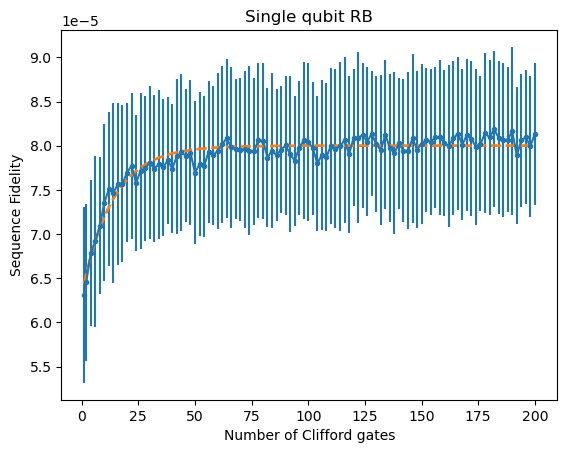

In [4]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
from scipy.optimize import curve_fit
import xarray as xr
def power_law(power, a, b, p):
    return a * (p**power) + b

def ana_SQRB( x, y ):
    
    pars, cov = curve_fit(
        f=power_law,
        xdata=x,
        ydata=y,
        p0=[0.5, 0.5, 0.9],
        bounds=(-np.inf, np.inf),
        maxfev=2000,
    )
    stdevs = np.sqrt(np.diag(cov))

    print("#########################")
    print("### Fitted Parameters ###")
    print("#########################")
    print(f"A = {pars[0]:.3} ({stdevs[0]:.1}), B = {pars[1]:.3} ({stdevs[1]:.1}), p = {pars[2]:.3} ({stdevs[2]:.1})")
    print("Covariance Matrix")
    print(cov)

    one_minus_p = 1 - pars[2]
    r_c = one_minus_p * (1 - 1 / 2**1)
    r_g = r_c / 1.875  # 1.875 is the average number of gates in clifford operation
    r_c_std = stdevs[2] * (1 - 1 / 2**1)
    r_g_std = r_c_std / 1.875

    print("#########################")
    print("### Useful Parameters ###")
    print("#########################")
    print(
        f"Error rate: 1-p = {np.format_float_scientific(one_minus_p, precision=2)} ({stdevs[2]:.1})\n"
        f"Clifford set infidelity: r_c = {np.format_float_scientific(r_c, precision=2)} ({r_c_std:.1})\n"
        f"Gate infidelity: r_g = {np.format_float_scientific(r_g, precision=2)}  ({r_g_std:.1})"
    )
    
    return pars

def plot_SQRB_result( x, y, yerr, fig:Figure=None ):

    fig, ax = plt.subplots()
    par = ana_SQRB( x, y )
    ax.errorbar(x, y, yerr=yerr, marker=".")
    ax.plot(x, power_law(x, *par), linestyle="--", linewidth=2)
    ax.set_xlabel("Number of Clifford gates")
    ax.set_ylabel("Sequence Fidelity")
    ax.set_title("Single qubit RB")

dataset = xr.open_dataset(r"d:\Data\5Qv4_0822_8_ITRIMixer\collection\1QRB_q1_xy_20240605_1919.nc")
print(dataset)


from qcat.visualization.qubit_relaxation import plot_time_dep_qubit_relaxation_2Dmap, plot_qubit_relaxation_hist
from qcat.qubit.relaxation import qubit_relaxation_fitting

q_name = "q1_xy"
x = dataset.coords["gate_number"].values
value_avg = dataset[q_name].values
error_avg = dataset[f"{q_name}_err"].values


plot_SQRB_result( x, value_avg, error_avg )
